# KAIROS Calibration Analysis

**This notebook produces the metrics reported in the README.**

It analyzes the probabilistic reliability of the KAIROS engine using Reliability Diagrams and ECE (Expected Calibration Error) metrics.

## 1. Setup & Data Loading

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import sys
import os

# Add project root to path
sys.path.append("..")

from src.kairos.data.loader import load_adult_data
from src.kairos.core.pipeline import KairosInferenceEngine
from src.kairos.core.calibration import compute_ece

# Visual Style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = [8, 8]

In [6]:
# Load strict test set split
df = load_adult_data("../data")
X = df.drop(columns=["target", "income", "fnlwgt", "education"])
y = df["target"]

# Identical split to main.py
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Load KAIROS Engine & Predict

In [7]:
MODEL_PATH = "../outputs/kairos_model"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(
        f"Please run 'python main.py' first to generate {MODEL_PATH}"
    )

engine = KairosInferenceEngine.load(MODEL_PATH)
probs = engine.predict_calibrated(X_test)

## 3. Reliability Diagram (Calibration Curve)

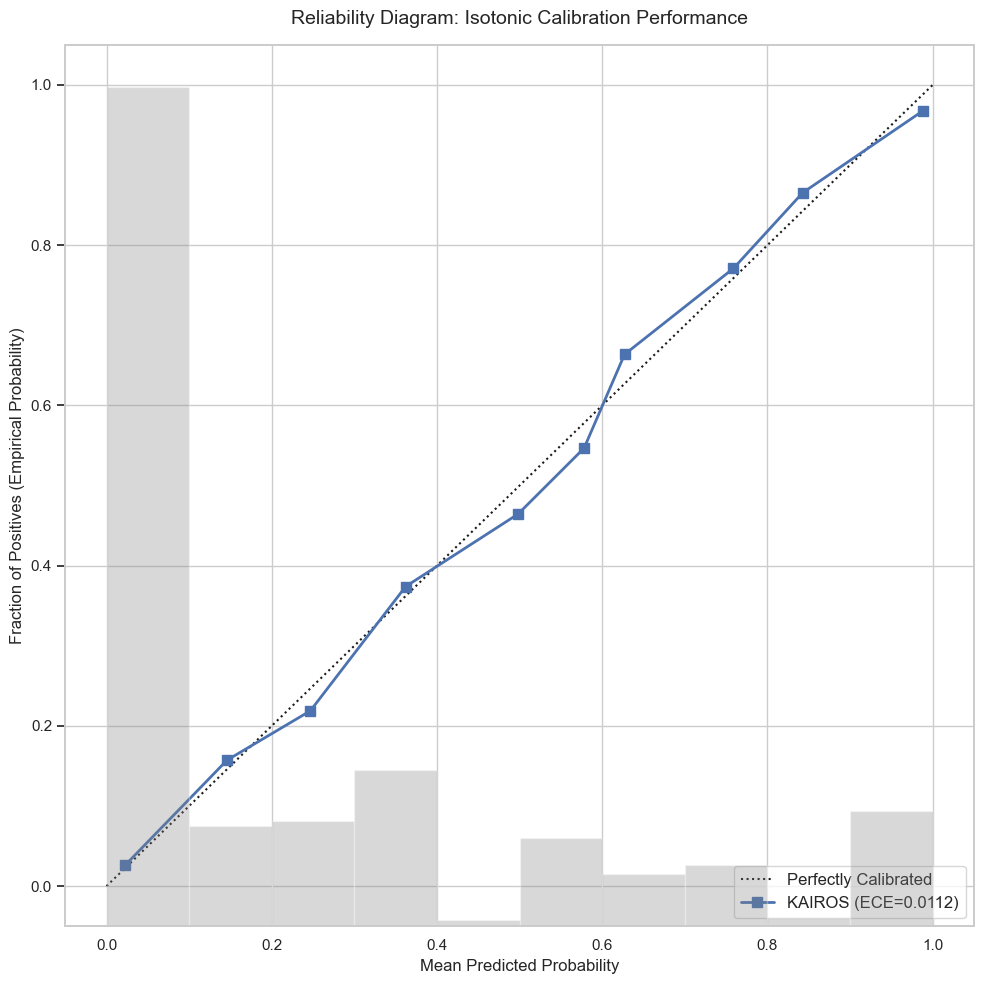

In [8]:
def plot_calibration_curve(y_true, y_prob, bins=10):
    # Compute Curve points
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=bins)

    # Compute ECE
    ece = compute_ece(y_true.values, y_prob, n_bins=bins)

    # Plot
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
    plt.plot(
        prob_pred,
        prob_true,
        "s-",
        label=f"KAIROS (ECE={ece:.4f})",
        linewidth=2,
        markersize=7,
    )

    plt.ylabel("Fraction of Positives (Empirical Probability)", fontsize=12)
    plt.xlabel("Mean Predicted Probability", fontsize=12)
    plt.title(
        "Reliability Diagram: Isotonic Calibration Performance", fontsize=14, pad=15
    )
    plt.legend(loc="lower right", fontsize=12)

    # Histogram of confidence
    plt.twinx()
    plt.hist(y_prob, bins=bins, alpha=0.3, color="gray", range=(0, 1))
    plt.yticks([])

    plt.tight_layout()
    plt.show()
    return ece


ece_score = plot_calibration_curve(y_test, probs)

## 4. Confidence Distribution Analysis
Verify that the model isn't just outputting 0.5 (Maximum Entropy) but is actually confident.

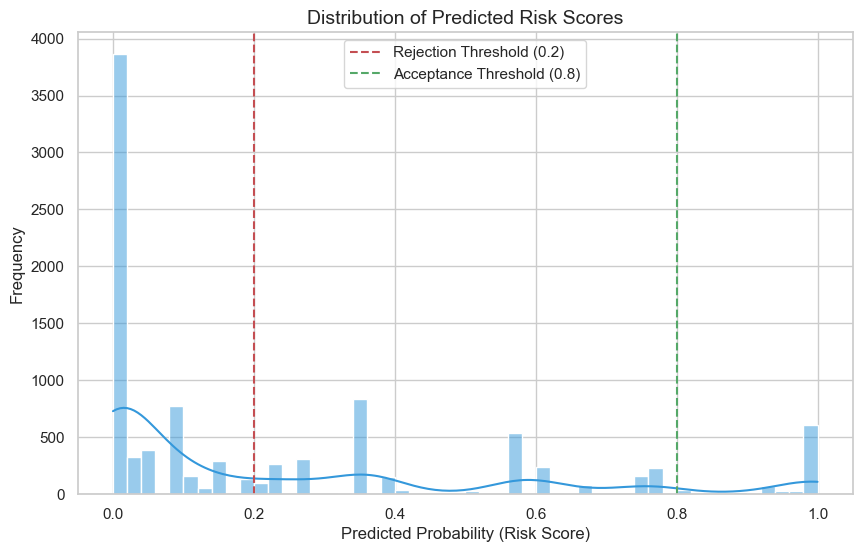

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(probs, bins=50, kde=True, color="#3498db")
plt.title("Distribution of Predicted Risk Scores", fontsize=14)
plt.xlabel("Predicted Probability (Risk Score)")
plt.ylabel("Frequency")
plt.axvline(x=0.2, color="r", linestyle="--", label="Rejection Threshold (0.2)")
plt.axvline(x=0.8, color="g", linestyle="--", label="Acceptance Threshold (0.8)")
plt.legend()
plt.show()